In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import seaborn as sns

In [2]:
#Dataframe creation from input datafile
dataframe = pd.read_csv("compas-scores-two-years1.csv")

In [3]:
#Dataframe creation from input datafile as backup before transformation
dataframe_temp = pd.read_csv("compas-scores-two-years1.csv")

In [4]:
#Feature Selection
dataframe2 = pd.DataFrame(dataframe,
                          columns=['age','race','juv_fel_count','juv_misd_count','juv_other_count','priors_count','is_violent_recid','decile_score','v_decile_score','priors_count','start','end','event'])

In [5]:
dataframe3 = pd.DataFrame(dataframe,
                          columns=['age','race','juv_fel_count','juv_misd_count','juv_other_count','priors_count','is_violent_recid','decile_score','v_decile_score','priors_count','start','end','event','two_year_recid'])

In [6]:
#Converting String to integer values for benefit of logistic regression which requires numerical data
mapping = {'African-American' : 0, 'Asian' : 1, 'Caucasian' : 2, 'Hispanic' : 3,'Native American' : 4, 'Other' : 5}
dataframe2 = dataframe2.replace({'race' : mapping})
dataframe3 = dataframe3.replace({'race' : mapping})
dataframe_temp = dataframe_temp.replace({'race' : mapping})

In [7]:
#Output labels
Y_labels = dataframe['labels']

In [8]:
#Ground truth - /unsure/
recid_status = dataframe['two_year_recid'].to_numpy()

In [9]:
#Array containing the races available in dataset
x = np.unique(dataframe['race'].to_numpy())

In [10]:
#Calculating race wise recidivism and no recidivism count. 
#Count for each race correspond indexes in array that were assigned in initial string to numerical reassign
race_recidivism_count = [0,0,0,0,0,0]
race_norecidivism_count = [0,0,0,0,0,0]
for i in range (len(dataframe_temp['race'])):
    if(dataframe_temp.iloc[i,-1] == 0):
        race_norecidivism_count[dataframe_temp['race'].iloc[i]] += 1
    else:
        race_recidivism_count[dataframe_temp['race'].iloc[i]] += 1

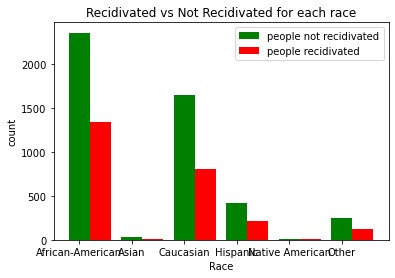

In [11]:
w = 0.4
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]

plt.bar(bar1,race_norecidivism_count,w,color = 'green',label = 'people not recidivated')
plt.bar(bar2,race_recidivism_count,w,color = 'red',label = 'people recidivated')
plt.title("Recidivated vs Not Recidivated for each race")
plt.xlabel('Race')
plt.ylabel('count')
plt.xticks(bar1,x)
plt.legend()


In [12]:
#Calculating race wise decile score count
x_afam = dataframe_temp.loc[dataframe_temp['race'] == 0,'decile_score'].values
x_asian = dataframe_temp.loc[dataframe_temp['race'] == 1,'decile_score'].values
x_cau = dataframe_temp.loc[dataframe_temp['race'] == 2,'decile_score'].values
x_his = dataframe_temp.loc[dataframe_temp['race'] == 3,'decile_score'].values
x_nat = dataframe_temp.loc[dataframe_temp['race'] == 4,'decile_score'].values
x_oth = dataframe_temp.loc[dataframe_temp['race'] == 5,'decile_score'].values

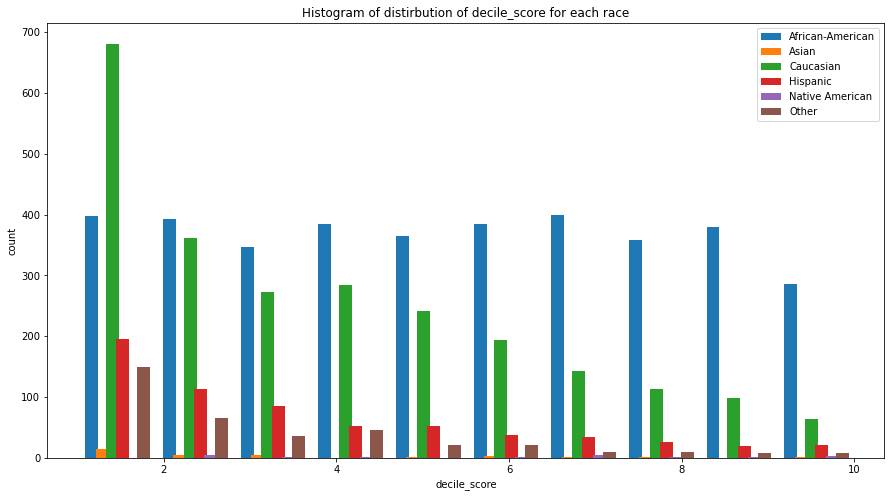

In [13]:
plt.rcParams["figure.figsize"] = (15,8)
plt.hist([x_afam,x_asian,x_cau,x_his,x_nat,x_oth],width = 0.15)
plt.title("Histogram of distirbution of decile_score for each race")
plt.xlabel('decile_score')
plt.ylabel('count')
plt.legend(['African-American','Asian','Caucasian','Hispanic','Native American','Other'])

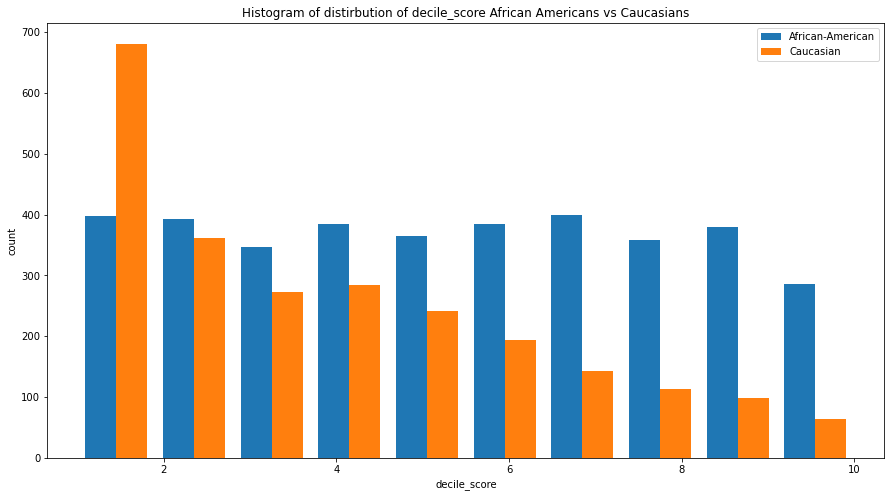

In [14]:
plt.rcParams["figure.figsize"] = (15,8)
plt.hist([x_afam,x_cau])
plt.title("Histogram of distirbution of decile_score African Americans vs Caucasians")
plt.xlabel('decile_score')
plt.ylabel('count')
plt.legend(['African-American','Caucasian'])

In [15]:
# Train test split. Train : 2/3 of total dataset
data_train,data_test,labels_train,labels_test = train_test_split(dataframe2, Y_labels,test_size = 0.33,random_state = 42,shuffle=False)

In [16]:
# Training model using logistic regression
lr = LogisticRegression()
lr.fit(data_train,labels_train)

/Users/harivigneshgomathi/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [17]:
# Predicting for test labels
pred = lr.predict(data_test)

In [18]:
labels_test_arr = labels_test.values

In [19]:
# Calculating accuracy of prediction.
# Note: Accuracy of the LR model is tested against Y_labels not against ground truth
count = 0
for i in range (len(pred)):
    if(pred[i] == labels_test_arr[i]):
        count+=1

avg = (count/len(pred))*100
print("Accuracy: ",avg)

Accuracy:  95.54808903821923


In [20]:
#Post prediction study vs Ground truth
#Calculating race wise false positives. Also for African american and Caucasians for Opprtunity cost /unsure/
false_positives = []
af_am_fp = 0
ca_fp = 0
race_false_positives = [0,0,0,0,0,0]
for i in range (len(pred)):
    if(pred[i] == 1 and recid_status[4833+i] == 0):
        race_false_positives[dataframe2['race'].iloc[i]] += 1
        false_positives.append(dataframe2['race'].iloc[i])
        if(dataframe2['race'].iloc[i] == 0):
            af_am_fp += 1
        if(dataframe2['race'].iloc[i] == 2):
            ca_fp += 1

In [21]:
if(len(false_positives) != 0):
    perc_af_am_fp = (af_am_fp / len(false_positives))*100
    perc_cauc_fp = (ca_fp / len(false_positives))*100
print("Ratio of African americans in false positive: ",af_am_fp,"/",len(false_positives))
print("Percentage: ",perc_af_am_fp)
print("Ratio of Caucasians in false positive: ",ca_fp,"/",len(false_positives))
print("Percentage: ",perc_cauc_fp)

Ratio of African americans in false positive:  217 / 430
Percentage:  50.46511627906977
Ratio of Caucasians in false positive:  147 / 430
Percentage:  34.18604651162791


In [22]:
y = race_false_positives

Text(0.5, 1.0, 'False positive count for each race')

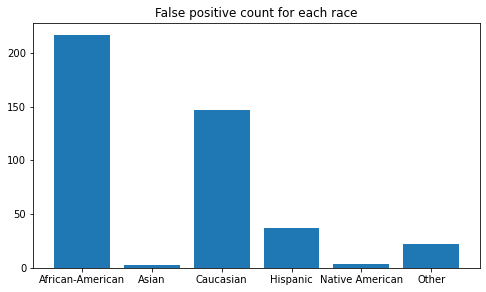

In [23]:
plt.rcParams["figure.figsize"] = (8,4.5)
plt.bar(x, y)
plt.title("False positive count for each race")

In [24]:
# Accuracy of prediction vs ground Truth
fp = 0
fn = 0
tp = 0
tn = 0
for i in range (len(pred)):
    if(pred[i] == 1 and recid_status[4833+i] == 0):
        fp += 1
    if(pred[i] == 0 and recid_status[4833+i] == 1):
        fn += 1
    if(pred[i] == 1 and recid_status[4833+i] == 1):
        tp += 1
    if(pred[i] == 0 and recid_status[4833+i] == 0):
        tn += 1

Text(0, 0.5, 'count')

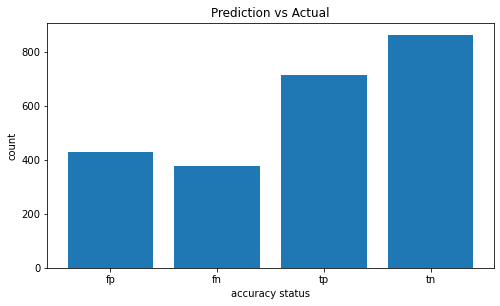

In [25]:
plt.bar(['fp','fn','tp','tn'],[fp,fn,tp,tn])
plt.title("Prediction vs Actual")
plt.xlabel('accuracy status')
plt.ylabel('count')

In [26]:
fp_p = (fp/len(pred))*100
fn_p = (fn/len(pred))*100
acc = ((tp+tn)/len(pred))*100

In [27]:
print(fp_p,fn_p,acc)

18.059638807223855 15.833683326333473 66.10667786644268


In [28]:
Afam_Dataframe_norec = dataframe3[(dataframe3['race'] == 0) & (dataframe3['two_year_recid'] == 0)]
Afam_Dataframe_rec = dataframe3[(dataframe3['race'] == 0) & (dataframe3['two_year_recid'] == 1)]

In [29]:
Cau_Dataframe_norec = dataframe3[(dataframe3['race'] == 2) & (dataframe3['two_year_recid'] == 0)]
Cau_Dataframe_rec = dataframe3[(dataframe3['race'] == 2) & (dataframe3['two_year_recid'] == 1)]

In [30]:
print(Afam_Dataframe_norec.shape,Afam_Dataframe_rec.shape,Cau_Dataframe_norec.shape,Cau_Dataframe_rec.shape)

(1795, 14) (1901, 14) (1488, 14) (966, 14)


In [31]:
Afam_Dataframe_norec_t = Afam_Dataframe_norec.sample(n=966)
Afam_Dataframe_rec_t = Afam_Dataframe_rec.sample(n=966)
Cau_Dataframe_norec_t = Cau_Dataframe_norec.sample(n=966)
Cau_Dataframe_rec_t = Cau_Dataframe_rec.sample(n=966)

In [32]:
Fin_Dataframe = pd.concat([Afam_Dataframe_norec_t,Afam_Dataframe_rec_t,Cau_Dataframe_norec_t,Cau_Dataframe_rec_t],axis = 0)

In [33]:
Fin_Dataframe

,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,is_violent_recid,decile_score,v_decile_score,priors_count,start,end,event,two_year_recid
6124,26,0,0,0,0,5,0,4,5,5,0,846,0,0
7112,26,0,0,0,0,0,0,2,3,0,3,867,0,0
1093,24,0,0,0,0,1,0,2,3,1,0,914,0,0
3512,29,0,0,0,0,0,0,2,2,0,0,837,0,0
871,30,0,0,0,0,4,0,3,3,4,0,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,52,2,0,0,0,6,0,5,3,6,1,162,1,1
6489,34,2,0,0,0,10,1,9,5,10,0,22,0,1
638,57,2,0,0,0,0,0,4,1,0,1,234,1,1
2181,39,2,0,0,0,3,1,1,1,3,0,673,1,1


In [34]:
Fin_labels = []
for i in range(len(Fin_Dataframe)):
    if(Fin_Dataframe['decile_score'].iloc[i] < 5):
        Fin_labels.append(0)
    else:
        Fin_labels.append(1)
Fin_labels = pd.DataFrame(Fin_labels)

In [35]:
Fin_Data_train,Fin_Data_test,Fin_labels_train,Fin_labels_test = train_test_split(Fin_Dataframe,Fin_labels,test_size = 0.33)

In [36]:
lr.fit(Fin_Data_train,Fin_labels_train)

/Users/harivigneshgomathi/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/harivigneshgomathi/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [37]:
Fin_pred = lr.predict(Fin_Data_test)

In [38]:
Fin_labels_test_arr = Fin_labels_test.values

In [39]:
count2 = 0
for i in range (len(Fin_pred)):
    if(Fin_pred[i] == Fin_labels_test_arr[i]):
        count2+=1

avg = (count2/len(Fin_pred))*100
print("Accuracy: ",avg)

Accuracy:  95.6896551724138
